In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


### Retrieve variables from Notebook 1 - Data Exploration

In [2]:
%store -r train_enhanced
%store -r categorical_vars
%store -r non_categorical_vars
%store -r nulls_details
%store -r non_sparse_features

In [3]:
train_enhanced.shape

(90811, 58)

In [4]:
non_categorical_vars.shape

(90811, 34)

# 0. Helper Functions

## 1. Data Preparation

In [5]:
# function that separates out features in a list into categorical and non-categorical variables
def categorise_features(features_list,categorical_features_df,non_categorical_features_df):
    
    categorical_features_list=[]
    non_categorical_features_list=[]
    
    for item in features_list:
        if item in list(categorical_features_df.columns):
            categorical_features_list.append(item)
        else:
            non_categorical_features_list.append(item)
            
    return categorical_features_list,non_categorical_features_list

### 1.1 Non Categorical Variables
Impute empty cells of non-categorical variables with the mean value.

In [6]:
from sklearn.preprocessing import Imputer

def impute_df(df):
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    col_names=df.columns
    return pd.DataFrame(imp.fit_transform(df),columns=col_names)

### 1.2 Categorical Variables
One hot encode categorical variables

In [7]:
def one_hot_encode(df):
    df_filled=df.fillna('NA')

    col_names=df.columns
    return pd.get_dummies(df_filled,columns=col_names)

### 1.3 Combine categorical AND non categorical variables

In [8]:
def process_features(categorical_vars,non_categorical_vars):
    encoded_vars=one_hot_encode(categorical_vars)
    imputed_vars=impute_df(non_categorical_vars)
    
    return encoded_vars.join(imputed_vars)


### 1.4 Feature Scaling, Standardizing and Normalizing

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

def scale_data(X,min_val,max_val):
    scaler=MinMaxScaler(feature_range=(min_val,max_val))
    rescaled_X=scaler.fit_transform(X)
    rescaled_X.columns=X.columns
    
    return rescaled_X

def standardize_data(X):
    scaler=StandardScaler()
    rescaled_X=pd.DataFrame(scaler.fit_transform(X))
    rescaled_X.columns=X.columns
    
    return rescaled_X

def normalize_data(X):
    scaler=Normalizer()
    normalized_X=pd.DataFrame(scaler.fit_transform(X))
    normalized_X.columns=X.columns
    
    return normalized_X

In [10]:
from sklearn.decomposition import PCA

def get_pca_features(X,n_components):
    pca=PCA(n_components)
    
    X_pca=pca.fit_transform(X)
    
    return X_pca

### 1.5 Diagnostic Functions

In [11]:
def print_categorical_details(cat_features_list):
    print("\nNumber of categorical variables: %d \n\n %s" % (len(cat_features_list),cat_features_list))
    
def print_non_categorical_details(nonCat_features_list):
    print("\nNumber of non categorical variables: %d \n\n %s" % (len(nonCat_features_list),nonCat_features_list))

## 2. Performance Metrics/Evaluation Functions

### 2.1 Coefficient of Determination $R^2$
As per the capstone proposal, one of the measures of performance is the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), $R^2$ = explained variance/total variance.  This is the proportion of the variation in the target variable that is explained by the linear model, and takes values between 0% and 100%.  The closer the $R^2$ value is to 100%, the better the model explains the variability of the target variable around its mean. An $R^2$ value of 0 indicates a model which always fails to predict the target variable, whilst 1 describes a model which perfectly predicts the target variable.

*A model can be given a negative $R^2$ as well, which indicates that the model is no better than one that naively predicts the mean of the target variable.*

In [12]:
# Import 'r2_score'.  Use `r2_score` from `sklearn.metrics` to perform a performance calculation between `y_true` and `y_predict`.
# Assign the performance score to the `score` variable.

from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true,y_predict)
    
    # Return the score
    return score

### 2.2 Mean Squared Error

In [13]:
# function to estimate the average sum of squared errors
def get_mse(predictions,actuals):
    errors=predictions-actuals
    sq_errors=errors*errors
    sse=sq_errors.sum()
    
    return sse/len(actuals)

# function to estimate the average sum of the squared errors using the mean of y_train as the predictor 
def get_mse_mean(y_train,actuals):
    mean_train=y_train.mean()
    SE_mean=mean_train-actuals
    SE_mean=SE_mean*SE_mean
    SSE_mean=SE_mean.sum()
    return SSE_mean/len(actuals)

In [14]:
# returns predictions from a model
def analyze_model(model,X_test,y_test):
    predictions=model.predict(X_test)
    print("r2 score: %.8f" % r2_score(y_test,predictions))
    return predictions

In [15]:
# returns predictions on both a training and a test dataset
def evaluate_model(X_test,y_test,X_train,y_train,model):
    test_pred=model.predict(X_test)
 
    train_pred=model.predict(X_train)

    r2=r2_score(y_test,test_pred)
    model_name=model.__class__.__name__
    mse=get_mse(test_pred,y_test)
    mse_mean=get_mse_mean(y_train,y_test)
    
    print("\nResults from {}: \n".format(model_name))
    print("r2 score: %.8f\n" % r2)
    print("MSE (model vs baseline): %.8f vs %.8f\n" % (mse,mse_mean))

    return test_pred,train_pred

In [16]:
def get_linear_model_perf(X,Y,model):    
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=123)
    
    model,r2=linear_model(model,X_train,y_train,X_test,y_test,print_graph=True,return_results=True)
    
    return model,r2

In [17]:
def get_best_overall_score(df,metric):
    best_index=df[metric].argmax()
    best_details=df.loc[best_index]
    
    best_model=best_details['model type']
    best_basis=best_details['basis']
    best_score=best_details[metric]
    best_data_source=best_details['Data']
    
    return best_score,best_basis,best_model,best_data_source

## 3. Plotting Functions

### 3.1 Residual Plots
Residual plots are used as the $R^2$ variable on its own is not able to determine if a model is biased.<sup>Ref:http://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit</sup>

In [18]:
def plot_residuals(predictions,actuals,title_text):
#PLOT
    fig1 = plt.figure(1)
    plt.title(title_text)
    #Plot Data-model
    frame1=fig1.add_axes((.0,.4,1.0,.5))
    #xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
    plt.plot(actuals,predictions,'.b',label="prediction") #predictions
    plt.plot(actuals,actuals,'.r',label="actual") #actuals
    frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
    plt.legend()
    plt.grid()

    #Residual plot
    difference = actuals - predictions
    frame2=fig1.add_axes((.0,.0,1.0,.4))        
    #plt.plot(actuals,difference,'or')
    #plt.plot(actuals,difference,'.b',label="Actual vs Prediction")
    plt.plot(actuals,difference,'.g',label="Actual less Prediction")
    plt.legend()
    plt.grid()



### 3.2 Actual vs Expected Plots

In [19]:
def AvE_plots(train_pred,train_y,test_pred,test_y,model):
#PLOT
    model_name=model.__class__.__name__
    plt.figure(figsize=(20,8))
    #fig1 = plt.figure(1)
    plt.subplot(1,2,1)
    plt.title("AvE Analysis (Training Data)- %s" % model_name)
    #Plot Data-model
#    frame1=fig1.add_axes((.0,.4,1.0,.5))
    #xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
    plt.plot(train_y,train_pred,'.b',label="prediction") #predictions
    plt.plot(train_y,train_y,'.r',label="actual") #actuals
#    fig1.set_xticklabels([]) #Remove x-tic labels for the first frame
    plt.legend()
    plt.grid()

    #Residual plot
    #fig2 = plt.figure(2)
    
    plt.subplot(1,2,2)
    plt.title("AvE Analysis (Test Data) - %s" % model_name)
    #Plot Data-model
#    frame2=fig2.add_axes((.0,.4,1.0,.5))
    #xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
    plt.plot(test_y,test_pred,'.b',label="prediction") #predictions
    plt.plot(test_y,test_y,'.r',label="actual") #actuals
#    fig2.set_xticklabels([]) #Remove x-tic labels for the first frame
    plt.legend()
    plt.grid()


### 3.3 Visualisations

In [20]:
def print_bar_plots(dataset,feature1,feature2,x_axis,label1,label2,sizeX,sizeY,title):
    fig,ax=plt.subplots()
    ax2=ax.twinx()
    fig.set_size_inches(sizeX,sizeY)
    plt.xticks(rotation=90)

    g1=sns.barplot(data=dataset,x=x_axis,y=feature1,ax=ax,color="blue",alpha=0.5,label=label1)
    g2=sns.barplot(data=dataset,x=x_axis,y=feature2,ax=ax2,color="red",alpha=0.5,label=label2)

    for item in g1.get_xticklabels():
        item.set_rotation(90)

    ax.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax.set_title(title)

In [21]:
def plot_horizontal_bars(x_size,y_size,title,dataset,plot_variable,y_axis,x_label):
    fig,ax= plt.subplots()
    fig.set_size_inches(x_size,y_size)

    items=np.arange(len(dataset[plot_variable]))
    rects = ax.barh(items,dataset[plot_variable], color='blue')
    ax.set_yticks(items)
    ax.set_yticklabels(dataset[y_axis], rotation='horizontal')
    ax.set_xlabel(x_label)
    ax.set_title(title)
    plt.show()

In [22]:
def plot_rf_importances(indices,features,importances,x_size,y_size):
    #plt.figure(1)
    fig,ax= plt.subplots()
    fig.set_size_inches(x_size,y_size)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features[indices])
    #plt.yticks(range(len(indices)))
    plt.xlabel('Relative Importance')

In [23]:
# this function plots subplot - need to specify total number of plots and plot position 

def plot_params(X,Y,x_label,y_label,title,plot_position,total_plots,fig):
#plot_params(params,scores,param_name,'r2',name,plot_position,num_plots,fig)
    #fig.subplots_adjust(hspace=.9)
    #fig.subplots_adjust(top=0.95)
    
    ax=fig.add_subplot(1,total_plots,plot_position)
    plt.plot(X,Y)
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    
#    fig.tight_layout()

In [24]:
def plot_linear_models(plot1,title1,label1,plot2,title2,label2,plot3,title3,label3,score,suptitle=""):

    fig=plt.figure(figsize=(15,5))
    fig.suptitle(suptitle)

    ax1=fig.add_subplot(1,3,1)
    plt.boxplot(plot1)
    ax1.set_title(title1)
    ax1.set_ylabel(score)
    ax1.set_xticklabels(label1)

    ax2=fig.add_subplot(1,3,2,sharey=ax1)
    ax2.set_title(title2)
    plt.boxplot(plot2)
    ax2.set_xticklabels(label2)

    ax3=fig.add_subplot(1,3,3,sharey=ax1)
    ax3.set_title(title3)
    plt.boxplot(plot3)
    ax3.set_xticklabels(label3)

    #fig.subplots)
    plt.show()

In [25]:
import seaborn as sns
def bar_plot_df(plot_df,ax,show_values=False):
    ax=sns.barplot(data=plot_df,x='model type',y='r2',hue='basis',palette=sns.xkcd_palette(['blue', 'red']))
    ax.set_xlabel="  "
    #    ax.legend(loc='upper right')
#    ax.legend(bbox_to_anchor=(1, 1.05))

    if show_values==True:
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
                height + 0,
                '{:1.2f}'.format(height/float(len(plot_df['r2']))),
                ha="center") 

## 4. Feature Importance Functions


### 4.1 XGBoost Functions

In [26]:
def train_xgb(X_train,y_train):
    dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)
    model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

    print("Number of features in training data: %d" % X_train.shape[1])
    
    return model

def evaluate_xgb(X_test,y_test,X_train,y_train,model):
    dtest = xgb.DMatrix(X_test, feature_names=X_test.columns.values)
    test_pred=model.predict(dtest)
 
    dtrain = xgb.DMatrix(X_train, feature_names=X_train.columns.values)
    train_pred=model.predict(dtrain)

    xgboost_r2=r2_score(y_test,test_pred)
    xgboost_model_name=model.__class__.__name__
    mse=get_mse(test_pred,y_test)
    mse_mean=get_mse_mean(y_train,y_test)
    
    print("\nResults from {}: \n".format(xgboost_model_name))
    print("r2 score: %.8f\n" % xgboost_r2)
    print("MSE (model vs baseline): %.8f vs %.8f\n" % (mse,mse_mean))

    return test_pred,train_pred

## 5. Modelling Functions

In [27]:
def run_model(model,X_train, y_train, X_test, y_test):
    # assumes 'model' variables is already initialized
    model.fit(X_train,y_train)
    print('fitted model:  ',model)
    predictions=model.predict(X_test)
    
    mse=get_mse(predictions,y_test)
    r2=r2_score(y_test,predictions)
    
    return model,r2,mse

### 5.1 PCA

In [28]:
from sklearn.decomposition import PCA

def run_pca(model_type,X,Y,pca_n_components,print_graph=False,return_results=False):
    
    # feature extraction
    pca=PCA(n_components=pca_n_components)
    fit=pca.fit(X)

    X_pca=pca.transform(X)

#    Y_all_pca=train_enhanced['logerror']

    X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca,Y,test_size=0.2,random_state=123)

    print("MODEL DETAILS:")
    print("\nTotal number of model features: %d" % (X_pca.shape[1]))
    
    model,r2=linear_model(model_type,X_pca_train,y_pca_train,X_pca_test,y_pca_test,print_graph,return_results)
    
    if return_results==True:
        return model,r2
    
def pca_grid_search(model,start_n,end_n,interval,X,Y):
    pca_dims=[]
    pca_r2_scores=[]
    pca_models=[]

    candidate_dims=np.arange(start_n,end_n,interval)

    for dim in candidate_dims:
        pca_model,r2=run_pca(model,X,Y,dim,print_graph=False,return_results=True)
        pca_dims.append(dim)
        pca_models.append(pca_model)
        pca_r2_scores.append(r2)
        
    return pca_dims,pca_r2_scores,pca_models

In [29]:
def evaluate_best_dim(r2_scores,dimensions,print_graph=False):
    best_dim=dimensions[r2_scores.index(max(r2_scores))]
    print('The optimal number of dimensions by r2 score is: %d.' % best_dim)
    
    if print_graph==True:
        plt.plot(dimensions,r2_scores)
        plt.title("r2 scores vs number of principal components")
        plt.xlabel("Number of principal components")
        plt.ylabel("r2 score")
        
    return best_dim

### 5.2 Linear Models

In [30]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNet
from sklearn.model_selection import KFold, cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score

def linear_model(model_type,X_train,y_train,X_test,y_test,print_graph=True,return_results=False):
    if model_type=='linear':
        model=LinearRegression()
    elif model_type=='lasso':
        model=Lasso(random_state=123)
    elif model_type=='ridge':
        model=Ridge(random_state=123)
    elif model_type=='lassoCV':
        model=LassoCV()
    elif model_type=='ridgeCV':
        model=RidgeCV() 
    elif model_type=='eNet':
        model=ElasticNet(random_state=123)

    model.fit(X_train,y_train)
    
    test_pred=model.predict(X_test)
    train_pred=model.predict(X_train)
    
    r2=r2_score(y_test,test_pred)
    model_name=model.__class__.__name__
    
    print("\nResults from {}: \n".format(model_name))
    print("r2 score: %.8f\n" % r2)
    print("MSE (predicted vs baseline): %.8f vs %.8f\n" % (get_mse(test_pred,y_test),get_mse_mean(y_train,y_test)))
    
    if print_graph==True:
        AvE_plots(train_pred,y_train,test_pred,y_test,model)
    
    if return_results==True:
        return model,r2

C:\ProgramData\Anaconda2\envs\neural_nets\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [31]:
def run_linear_models(models,X,Y,nFolds,scoring,random_state=123):
    results=[]
    names=[]

    counter=1
        
    for name,model in models:
        print("Model %s: %s"%(counter,model))
        
        kfold=KFold(n_splits=nFolds,random_state=random_state)
        #cv_results=cross_val_score(model,X,Y,cv=kfold,scoring="r2")
        cv_results=cross_val_score(model,X,Y,cv=kfold,scoring=scoring)
#        print("success!")
        results.append(cv_results)
        names.append(name)
        
        counter+=1
        
    return names,results

In [32]:
def get_model_perf(X,Y,model):    
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
    
    model,r2=linear_model(model,X_train,y_train,X_test,y_test,print_graph=True,return_results=True)
    
    return model,r2

In [33]:
def get_tuned_param(data_name,model_name,param_type,best_params_df):
    model_df=best_params_df[best_params_df['model']==model_name]
    model_data_df=model_df[model_df['Data']==data_name]
    best_param=model_data_df['best_param'][(model_data_df['param_type']==param_type)]
    return float(best_param)

In [34]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet

def get_tuned_model(data_desc,model_name,best_param_df):
#    print('Tuning %s model ..... '%model_name)
    if model_name=='linear':
        model=LinearRegression()
    if model_name=='ridge':
        alpha=get_tuned_param(data_desc,model_name,'alpha',best_param_df)
        model=Ridge(alpha=alpha,random_state=123)
    if model_name=='lasso':
        alpha=get_tuned_param(data_desc,model_name,'alpha',best_param_df)
        model=Lasso(alpha=alpha,random_state=123)
    if model_name=='eNet':
        alpha=get_tuned_param(data_desc,model_name,'alpha',best_param_df)
        l1_ratio=get_tuned_param(data_desc,model_name,'l1_ratio',best_param_df)
        model=ElasticNet(alpha=alpha,l1_ratio=l1_ratio,random_state=123)
    
#    print('returning tuned model: ... %s ' %model)
    return model


In [35]:
def run_comparisons(data_dict,model_list,best_params_df):
    scoring='r2'
    nFolds=10
    
    model_results_list=[]
    model_names_list=[]
    data_names_list=[]
    
    
    
    for data_name,data_item in data_dict.items():
        optimised_models=[]

        X,Y=data_item
        print("===========================Processing %s  =============================" % data_name)
    
        for model_name in model_list:
            print("Now processing %s" %model_name)
            if model_name=='linear':
                optimised_models.append(('linear',LinearRegression()))
            if model_name=='ridge':
                alpha=get_tuned_param(data_name,model_name,'alpha',best_params_df)
                model=Ridge(alpha=alpha,random_state=123)
                optimised_models.append(('ridge',model))
            if model_name=='lasso':
                alpha=float(get_tuned_param(data_name,model_name,'alpha',best_params_df))
                model=Lasso(alpha=alpha,random_state=123)
                optimised_models.append(('lasso',model))
            if model_name=='eNet':
                alpha=float(get_tuned_param(data_name,model_name,'alpha',best_params_df))
                l1_ratio=float(get_tuned_param(data_name,model_name,'l1_ratio',best_params_df))
                model=ElasticNet(alpha=alpha,l1_ratio=l1_ratio,random_state=123)
                optimised_models.append(('eNet',model))
            print("Finished Initializing model: %s" % model_name)

        print("===========================Running Linear Models %s  =============================" % data_name)
        
        model_names,model_results=run_linear_models(optimised_models,X,Y,nFolds,scoring)
            
        model_names_list.append(model_names)
        model_results_list.append(model_results)
        data_names_list.append(data_name)
    
    return data_names_list,model_names_list,model_results_list          

#### 5.2.2 Tuning Functions

In [36]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
    
def tune_ridge(alphas,X,Y):
    # the default ridge model uses alpha=1.0.  The selected alphas have been based on values around this default
    
    model=Ridge(random_state=123)
    #grid=GridSearchCV(estimator=model,param_grid=dict(alpha=alphas),scoring=scoring)
    grid=GridSearchCV(estimator=model,param_grid=dict(alpha=alphas),scoring=make_scorer(r2_score))
    grid.fit(X,Y)
    
    best_alpha=grid.best_estimator_.alpha
    best_score=grid.best_score_
    print("Best estimated alpha: %.8f" % best_alpha)
    print("Best score from grid: %.8f" % best_score)
    
    #return grid.cv_results_
    return grid,best_alpha,best_score


def tune_lasso(alphas,X,Y):
    # the default lasso model uses alpha=1.0.  The selected alphas have been based on values around this default
    
    model=Lasso(random_state=123)
    #grid=GridSearchCV(estimator=model,param_grid=dict(alpha=alphas),scoring=scoring)
    grid=GridSearchCV(estimator=model,param_grid=dict(alpha=alphas),scoring=make_scorer(r2_score))
    grid.fit(X,Y)
    
    best_alpha=grid.best_estimator_.alpha
    best_score=grid.best_score_
    print("Best estimated alpha: %.8f" % best_alpha)
    print("Best score from grid: %.8f" % best_score)
    
    #return grid.cv_results_
    return grid,best_alpha,best_score

def tune_eNet(alphas,l1_ratios,X,Y):
    # the default elastic net model uses alpha=1.0 and l1_ratio=0.5.  The selected alphas have been based on values around this default
    from sklearn.linear_model import ElasticNet
    
    parameters=dict(alpha=alphas,l1_ratio=l1_ratios)
    
    model=ElasticNet(random_state=123)
    grid=GridSearchCV(estimator=model,param_grid=parameters,scoring=make_scorer(r2_score))
    grid.fit(X,Y)
    
    best_alpha=grid.best_estimator_.alpha
    best_l1=grid.best_estimator_.l1_ratio
    best_score=grid.best_score_
    print("Best estimated alpha: %.8f" % best_alpha)
    print("Best estimated l1_ratio: %.8f" % best_l1)
    print("Best score from grid: %.8f" % best_score)
    
    #return grid.cv_results_
    return grid,best_alpha,best_l1,best_score

#### 5.2.3 Analyzing Tuned Networks

In [37]:
def get_param_values(grid,param):
    item_list=[]
    model_params=grid.cv_results_.get('params')
    for item in model_params:
        item_list.append(item.get(param))
        
    return item_list


In [38]:
def get_params_n_scores(grids,param_name,to_sort=True):
    from operator import itemgetter # for sorting list of params
    
    params=[]
    scores=[]

    for grid in grids:
    # get the alphas
        params=params+list(get_param_values(grid,param_name))
        scores=scores+list(grid.cv_results_.get('mean_test_score'))
        
    
    sorted_list=[list(x) for x in zip(*sorted(zip(params, scores), key=itemgetter(0)))]
    params_sorted=sorted_list[0]
    scores_sorted=sorted_list[1]

    if to_sort==True:
        return params_sorted,scores_sorted
    else:
        return params,scores
    
import operator
import matplotlib.pyplot as plt

In [39]:
def get_best_param_n_score(params,scores):

#    plt.plot(params,scores)
#    plt.xlabel('alpha')
#    plt.ylabel('r2')

    max_index, max_value = max(enumerate(scores), key=operator.itemgetter(1))

    max_param=params[max_index]
    print("max_value: %.12f  max_alpha: %.4f" % (max_value,max_param))
    
    return max_param,max_value


In [40]:
def show_best_scores(data_dict,param_name,model_name,fig_x_size=15,fig_y_size=5):
    num_items=len(data_dict)

    best_names=[]
    best_scores=[]
    best_params=[]

    num_plots=len(data_dict)
    plot_position=1
    
    fig=plt.figure(figsize=(fig_x_size,fig_y_size))
    fig.suptitle(model_name)
    
    for name,data_items in data_dict.items():
        grids=data_items
    
        params,scores=get_params_n_scores(grids,param_name)
        best_param,best_score=get_best_param_n_score(params,scores)

        best_params.append(best_param)
        best_scores.append(best_score)
        best_names.append(name)
    
        #ax=fig.add_subplot(1,num_plots,plot_position)
        #plot_params(params,scores,param_name,'r2',name,ax)
        #ax.set_title(title)
        #ax.set_ylabel(y_label)
        #ax.set_xlabel(x_label)

        plot_params(params,scores,param_name,'r2',name,plot_position,num_plots,fig)
              
        plot_position+=1
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    #plt.show()    
    return best_names,best_params,best_scores

In [41]:
# compile database of 'best' parameters

def create_param_df(params,scores,descriptions,param_type,model_type):
    df=pd.DataFrame(np.array(descriptions),columns=['Data'])
    df['param_type']=np.array(param_type)
    df['best_param']=np.array(params)
    df['best_score']=np.array(scores)
    df['model']=model_type
    
    return df

#### 5.5 Linear Model Specific comparison and visualisation functions

In [42]:
# this function is specific for the linear model comparison dataframe which has specific columns
def get_table(df,metric):
    df_pivot=df.pivot(index='model type',columns='basis',values=metric)
    return df_pivot

# this function is specific for plotting the linear model comparison results as it has specific columns
def plot_comparison(plot_df,metric,ax,have_legend=True):
    title=plot_df['Data'].unique()[0]
    ax.set_title(title)
    df_pivot=plot_df.pivot(index='model type',columns='basis',values=metric)
    df_pivot=df_pivot.reindex(['linear','lasso','ridge','eNet'])
    #df_pivot.reindex(['linear','lasso','ridge','eNet'])
    df_pivot.plot.bar(ax=ax,color=['red','blue'])
    ax.set_ylabel(metric)
    if have_legend==True:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
    else:
        ax.legend_.remove()
        
# this function is specific for evaluating the linear model comparison dataframe which has specific columns
def get_best_score(df,metric):
    best_index=df[metric].argmax()
    best_details=df.loc[best_index]
    
    best_model=best_details['model type']
    best_basis=best_details['basis']
    best_score=best_details[metric]
    
    return best_score,best_basis,best_model

## 6. Neural Networks

In [43]:
from keras.models import Sequential
from keras.layers import Dense
import numpy
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold

# baseline model has a single fully connected hidden layer with the same number of neurons as inputs.
# it also uses the rectifier activation function for the hidden layer.
# the output layer has no activation function as this is a regression problem and we do not want to 
# transform the predicted values.  The ADAM optimization algorithm is used, and the mean squared error 
# loss function is optimized.

def NN_baseModel(num_inputs,num_hidden_layers=1):
    numpy.random.seed(123)
    
    model=Sequential()
    model.add(Dense(num_inputs,input_dim=num_inputs,kernel_initializer='normal',activation='relu'))
    
    hidden_layer_count=0
    
    while hidden_layer_count<num_hidden_layers:
        model.add(Dense(num_inputs,init='normal',activation='relu'))
        hidden_layer_count+=1
    
    model.add(Dense(1,init='normal'))
    
    model.compile(loss='mean_squared_error',optimizer='adam',metrics=[])
    
    return model

def run_NN_baseModel(X_train,y_train,X_test,y_test,num_epochs,batchSize,num_hidden_layers):
    np.random.seed(123)
    num_vars=X_train.shape[1]
    
    model=NN_baseModel(num_vars,num_hidden_layers)
    
    estimator=KerasRegressor(build_fn=NN_baseModel(num_vars,num_hidden_layers),epochs=num_epochs,batch_size=batchSize,verbose=0)
    
    kFold=KFold(n_splits=10,random_state=123)
    
    cv_results=cross_val_score(estimator,X_train,y_train,cv=kFold)
    
    model.fit(X_train,y_train,epochs=num_epochs,batch_size=batchSize)
    score=model.evaluate(X_test,y_test,batch_size=batchSize)
    
    return model,score,cv_results

def run_NN_(num_inputs,X,Y,num_hidden_layers=1):

    # Evaluate baseline model
    estimator=KerasRegressor(build_fn=NN_baseline(num_inputs,num_hidden_layers),nb_epoch=5,batch_size=100,verbose=0)

    kfold=KFold(n_splits=10,random_state=123)
    results=cross_val_score(estimator,X,Y,cv=kfold)

    print("Baseline model results\n mean: %.8f   stdev: %.8f" % (results.mean(),results.std()))
    
    return results,estimator

#############################################

from sklearn.model_selection import KFold

def cross_val(model,X,Y,num_epochs,batchSize,n_splits=10,random_state=123,verbose=False):

    kFold=KFold(n_splits=n_splits,random_state=random_state,shuffle=True)

    models=[]
    scores=[]
    for train_index,test_index in kFold.split(X,Y):
        X_train=X.iloc[train_index]
        y_train=Y.iloc[train_index]
        X_test=X.iloc[test_index]
        y_test=Y.iloc[test_index]
        #print("X_Train:",X_train.shape,"y_train: ",y_train.shape,"x_test:",y_test.shape)
        
        model.fit(np.array(X_train),np.array(y_train),epochs=num_epochs,batch_size=batchSize,verbose=verbose)
        score=model.evaluate(np.array(X_test),np.array(y_test),batch_size=batchSize)
    
        models.append(model)
        scores.append(score)
    return models,scores

# returns a neural network with the specified number of hidden layers
def run_NN(X_train,y_train,X_test,y_test,num_epochs,batchSize,num_hidden_layers,random_state=123,verbose=False):
    np.random.seed(random_state)
    num_vars=X_train.shape[1]
    
    model=NN_baseModel(num_vars,num_hidden_layers)

    model.fit(np.array(X_train),np.array(y_train),epochs=num_epochs,batch_size=batchSize,verbose=verbose)
    score=model.evaluate(np.array(X_test),np.array(y_test),batch_size=batchSize)

    cv_models,cv_scores=cross_val(model=model,X=X_train,Y=y_train,num_epochs=num_epochs,batchSize=batchSize,random_state=random_state,n_splits=10,verbose=verbose)
    print("Model r2 scores\n mean: %.8f   stdev: %.8f" % (np.mean(cv_scores),np.std(cv_scores)))
    
    return model,score,cv_models,cv_scores
    

Using TensorFlow backend.


### 6.1 NN Visualisations and Comparison Functions

In [44]:
# this function is specific for the neural network model comparison dataframe which has specific columns
def nn_plot(plot_data,ax,title,have_legend=False):
    plot_df=pd.DataFrame(dict(zip(list(plot_data['Hidden Layers']),list(plot_data['cv_scores']))))
    
    ax=plot_df.boxplot()
    ax.plot(plot_data['Hidden Layers'],plot_data['test_mse'],'r.')
    
    ax.grid(False)
    ax.set_xlabel('Hidden Layers')
    ax.set_ylabel('mse')
    ax.set_title(title)
    
    if have_legend==True:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
#    else:
#        ax.legend_.remove()

In [45]:
def get_best_score_nn(df,metric):
    best_index=df[metric].argmin()
    
    best_score=df.loc[best_index][metric]
    best_model=df.loc[best_index]['Hidden Layers']
    best_basis=df.loc[best_index]['Data Source']
    
    return best_score,best_basis,best_model

# 1. Analysis

## 1.1 Feature Importance
As there are a large number of features if we apply one hot encoding to the identified categorical variables, in this section I run a few indicative models to see what the important features are.

#### Prepare data for determining feature importance

In [46]:
from sklearn.cross_validation import train_test_split
 
X_all=process_features(train_enhanced[categorical_vars.columns],train_enhanced[non_categorical_vars.columns])
Y_all=train_enhanced['logerror']

# Shuffle and split the data into training and testing subsets
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all,Y_all,test_size=0.2,random_state=123)

In [47]:
X_all_standardized=standardize_data(X_all)

# Shuffle and split the data into training and testing subsets
X_all_standardized_train, X_all_standardized_test, y_all_standardized_train, y_all_standardized_test = train_test_split(X_all_standardized,Y_all,test_size=0.2,random_state=123)

In [48]:
X_all_normalized=normalize_data(X_all)

# Shuffle and split the data into training and testing subsets
X_all_normalized_train, X_all_normalized_test, y_all_normalized_train, y_all_normalized_test = \
train_test_split(X_all_normalized,Y_all,test_size=0.2,random_state=123)

### 1.1.1 XGBoost

In [49]:
import os
mingw_path='C:\\Program Files\\mingw-w64\\x86_64-7.1.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH']=mingw_path + ';' + os.environ['PATH']

In [50]:
from sklearn import model_selection, preprocessing
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
    
#train_y = trainFilterd.logerror.values
##train_X = trainFilterd.drop(["parcelid", "transactiondate", "logerror","abs_logerror"], axis=1)
#train_X = trainFilterd.drop(["logerror","abs_logerror"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}


In [51]:
data_desc=[]
xgb_models=[]
xgb_test_preds=[]
xgb_train_preds=[]

data_dict={'X_all':[X_all_train,y_all_train,X_all_test,y_all_test],
          'X_all_standardized':[X_all_standardized_train,y_all_train,X_all_standardized_test,y_all_test]}   

for name,data_items in data_dict.items():
    X_train,y_train,X_test,y_test=data_items
    
    model=train_xgb(X_train,y_train)
    
    data_desc.append(name)
    xgb_models.append(model)
    
    test_pred,train_pred=evaluate_xgb(X_test,y_test,X_train,y_train,model)
    
    xgb_test_preds.append(test_pred)
    xgb_train_preds.append(train_pred)
    

Number of features in training data: 3233

Results from Booster: 

r2 score: 0.01047186

MSE (model vs baseline): 0.02438002 vs 0.02463887

Number of features in training data: 3233

Results from Booster: 

r2 score: 0.01027348

MSE (model vs baseline): 0.02438491 vs 0.02463887



**Comment**: Standardising seems to make very little difference to the r2 score.  This is not surprising as gradient boosted trees are generally scale invariant.

In [52]:
importance =xgb_models[0].get_fscore()
xgbFeatures=pd.DataFrame(list(importance.items()), columns=['Item', 'Importance'])
xgbFeatures=xgbFeatures.sort_values(by=['Importance'],ascending=False)
xgbFeatures

,Item,Importance
149,transaction_mth,286
200,transaction_day,217
271,calc_tot_living_area,168
253,lot_area,132
38,tot_property_tax,131
292,longitude,130
207,structure_tax_value,117
234,latitude,111
230,finished_living_area,96
208,bldg_age,89


In [53]:
xgbFeatures.shape

(344, 2)

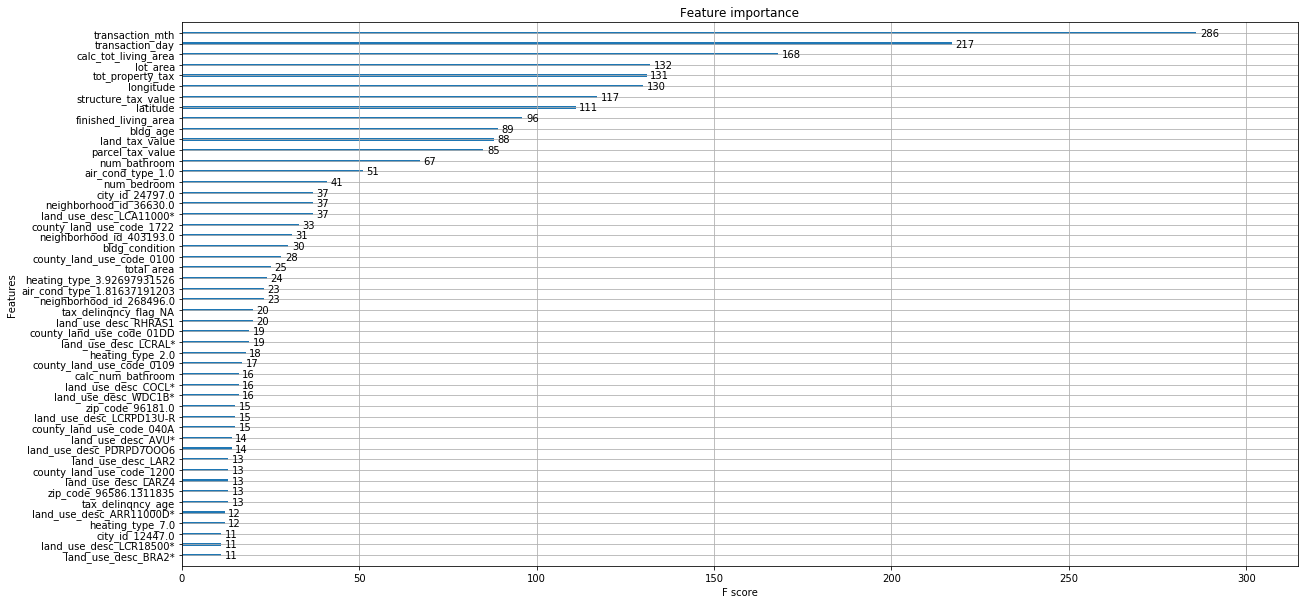

In [54]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(20,10))
plot_importance(booster=xgb_models[0],max_num_features=50, ax=ax)

### 1.1.2 Random Forest

In [55]:
from sklearn.ensemble import RandomForestRegressor

rf_data_desc=[]
rf_models=[]
rf_test_preds=[]
rf_train_preds=[]

data_dict={'X_all':[X_all_train,y_all_train,X_all_test,y_all_test],
          'X_all_standardized':[X_all_standardized_train,y_all_train,X_all_standardized_test,y_all_test]}   

for name,data_items in data_dict.items():
    X_train,y_train,X_test,y_test=data_items
    
    model=RandomForestRegressor()
    model.fit(X_train,y_train)

    rf_data_desc.append(name)
    rf_models.append(model)
    
    rf_test_pred,rf_train_pred=evaluate_model(X_test,y_test,X_train,y_train,model)
    
    #rf_test_pred=model.predict(X_test)
    #rf_train_pred=model.predict(X_test)
    
    rf_test_preds.append(rf_test_pred)
    rf_train_preds.append(rf_train_pred)

#train_y = trainFilterd.logerror.values
#train_X = trainFilterd.drop(["logerror","abs_logerror"], axis=1)

#forestModel=RandomForestRegressor()
#forestModel.fit(X_all_train,y_all_train)

#names=X_all_train.columns

# print("Features sorted by their score:")
# print(sorted(zip(map(lambda x: round(x, 4), forestModel.feature_importances_), names), reverse=True))


Results from RandomForestRegressor: 

r2 score: -0.16432368

MSE (model vs baseline): 0.02868664 vs 0.02463887


Results from RandomForestRegressor: 

r2 score: -0.16178354

MSE (model vs baseline): 0.02862406 vs 0.02463887



**Comment:** Random forest model performs very poorly as seen by the negative r2 scores and the MSE values which are higher than the baseline.

#### Random Forest on X_all

In [56]:
importances = model.feature_importances_
features=X_all.columns

rf_importances = pd.DataFrame({'Feature':features, 'Importance':importances})
rf_importances = rf_importances.sort_values(by='Importance',ascending=False)

rf_importances

,Feature,Importance
3200,transaction_day,0.062576
3227,structure_tax_value,0.057933
3217,latitude,0.053093
3230,tot_property_tax,0.052673
3218,longitude,0.052278
3199,transaction_mth,0.051086
3229,land_tax_value,0.049338
3219,lot_area,0.045692
3228,parcel_tax_value,0.044661
3207,calc_tot_living_area,0.043477


***Looking at the top 50 features***

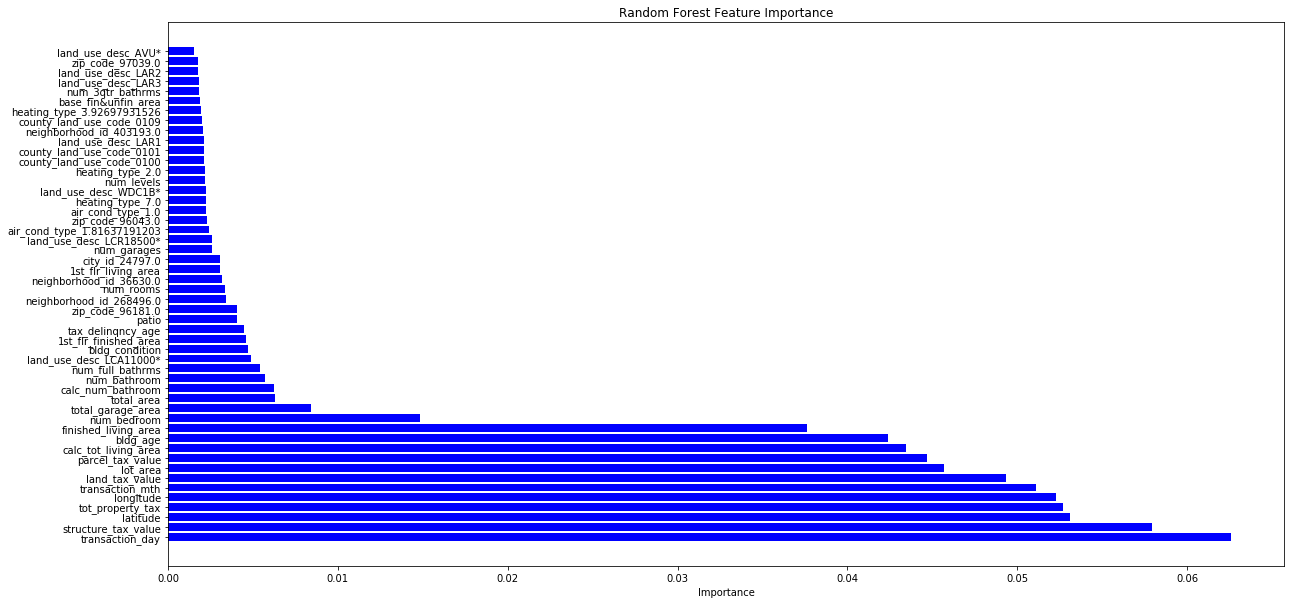

In [57]:
plot_horizontal_bars(20,10,"Random Forest Feature Importance",\
                     rf_importances[:50],'Importance','Feature','Importance')

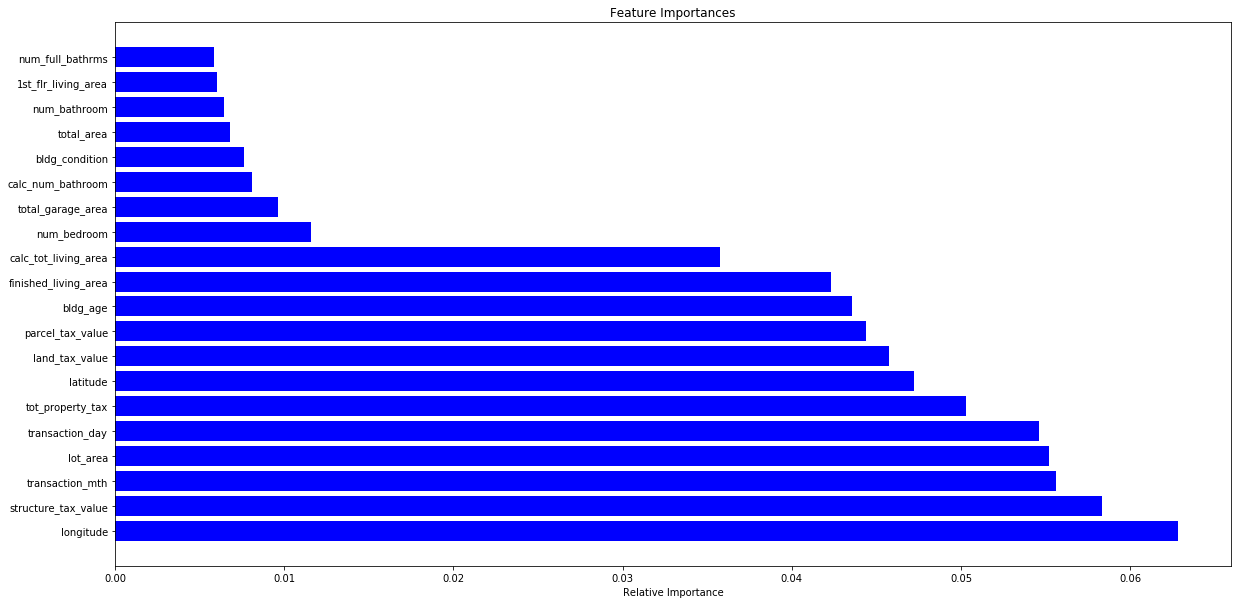

In [58]:
model=rf_models[0]
importances = model.feature_importances_
features=X_all.columns

indices = np.argsort(importances)[::-1]
indices_50=indices[:20]

plot_rf_importances(indices_50,features,importances,20,10)

## 1.2. PCA
PCA Analysis on **all** and ***non-sparse*** variables

In [ ]:
non_sparse_categorical_features,non_sparse_non_categorical_features=categorise_features(non_sparse_features,categorical_vars,\
                    non_categorical_vars)

X_non_sparse=process_features(train_enhanced[non_sparse_categorical_features],train_enhanced[non_sparse_non_categorical_features])
Y_non_sparse=train_enhanced['logerror']

In [ ]:
# see what number of dimensions yield the best results
pca_dims_all,pca_r2_scores_all,pca_models_all=pca_grid_search('linear',20,505,10,X_all,Y_all)
pca_dims_ns,pca_r2_scores_ns,pca_models_ns=pca_grid_search('linear',20,505,10,X_non_sparse,Y_non_sparse)

MODEL DETAILS:

Total number of model features: 20

Results from LinearRegression: 

r2 score: 0.00429287

MSE (predicted vs baseline): 0.02453226 vs 0.02463887

MODEL DETAILS:

Total number of model features: 30

Results from LinearRegression: 

r2 score: 0.00402285

MSE (predicted vs baseline): 0.02453891 vs 0.02463887

MODEL DETAILS:

Total number of model features: 40

Results from LinearRegression: 

r2 score: 0.00465831

MSE (predicted vs baseline): 0.02452326 vs 0.02463887

MODEL DETAILS:

Total number of model features: 50

Results from LinearRegression: 

r2 score: 0.00848380

MSE (predicted vs baseline): 0.02442900 vs 0.02463887

MODEL DETAILS:

Total number of model features: 60

Results from LinearRegression: 

r2 score: 0.00899261

MSE (predicted vs baseline): 0.02441647 vs 0.02463887

MODEL DETAILS:

Total number of model features: 70

Results from LinearRegression: 

r2 score: 0.00939860

MSE (predicted vs baseline): 0.02440647 vs 0.02463887

MODEL DETAILS:

Total number

In [ ]:
best_dim_all=evaluate_best_dim(pca_r2_scores_all,pca_dims_all,print_graph=True)

In [ ]:
best_dim_ns=evaluate_best_dim(pca_r2_scores_ns,pca_dims_ns,print_graph=True)

## 1.3. Feature selection

Options for feature selections are:
1. xgbFeatures - 350 features obtained from the xgboost model
2. pcaFeatures - 290 components run on X_all

Evaluate the performance of each of these two feature sets on a Linear Regression model

In [ ]:
num_pca_features_all=290

In [ ]:
X_all_pca=pd.DataFrame(get_pca_features(X_all,num_pca_features_all))

In [ ]:
X_select=X_all[list(xgbFeatures['Item'])]

### 1.3.1 Transform features

In [ ]:
# use original pca data
X_all_pca=pd.DataFrame(X_all_pca)

# standardised data
X_all_pca_s=standardize_data(pd.DataFrame(X_all_pca))
Y_all_pca_s=Y_all

# normalize data
X_all_pca_n=normalize_data(X_all_pca)

In [ ]:
%store X_all_pca

In [ ]:
%store X_all_pca
%store X_select

#### Check correlations between pca variables and logerror

In [ ]:
# check correlation coefficient of the newly created pca variables #
x_cols = [col for col in X_all_pca.columns if col not in ['logerror','abs_logerror','transactiondate','parcelid']]
cur_col=''
items = []
correlations = []
for col in x_cols:
    cur_col=col # cur_col is a diagnostic variable, and is only used for troubleshooting
    items.append(col)
    correlations.append(np.corrcoef(X_all_pca[col].values, Y_all.values)[0,1])

corr_df = pd.DataFrame({'col_labels':items, 'corr_values':correlations})
corr_df = corr_df.sort_values(by='corr_values')

plot_horizontal_bars(20,10,"Correlation coefficient with respect to logerror",\
                     corr_df,'corr_values','col_labels','correlation')


## Correlations Non Normalized, Non Standardized PCA  Components

#### Check correlations <u>between</u> pca variables

In [ ]:
# correlation matrix
fig,ax= plt.subplots(figsize=(5,5))
fig.suptitle('Correlations - PCA Variables')
cax=ax.matshow(X_all_pca.corr(),vmin=-1,vmax=1,interpolation='none')
fig.colorbar(cax)
#ax.set_title('All Variables')
ax.set_ylabel('feature')
plt.show()

## Check correlations on Standardized PCA components

In [ ]:
# check correlation coefficient of the newly created pca variables #
x_cols = [col for col in X_all_pca_s.columns if col not in ['logerror','abs_logerror','transactiondate','parcelid']]
cur_col=''
items = []
correlations = []
for col in x_cols:
    cur_col=col # cur_col is a diagnostic variable, and is only used for troubleshooting
    items.append(col)
    correlations.append(np.corrcoef(X_all_pca[col].values, Y_all.values)[0,1])

corr_df = pd.DataFrame({'col_labels':items, 'corr_values':correlations})
corr_df = corr_df.sort_values(by='corr_values')

plot_horizontal_bars(20,10,"Correlation coefficient with respect to logerror",\
                     corr_df,'corr_values','col_labels','correlation')


In [ ]:
# correlation matrix
fig,ax= plt.subplots(figsize=(5,5))
fig.suptitle('Correlations - PCA Variables')
cax=ax.matshow(X_all_pca_s.corr(),vmin=-1,vmax=1,interpolation='none')
fig.colorbar(cax)
#ax.set_title('All Variables')
ax.set_ylabel('feature')
plt.show()

## Correlations between Normalized PCA variables

In [ ]:
# check correlation coefficient of the newly created pca variables #
x_cols = [col for col in X_all_pca_n.columns if col not in ['logerror','abs_logerror','transactiondate','parcelid']]
cur_col=''
items = []
correlations = []
for col in x_cols:
    cur_col=col # cur_col is a diagnostic variable, and is only used for troubleshooting
    items.append(col)
    correlations.append(np.corrcoef(X_all_pca[col].values, Y_all.values)[0,1])

corr_df = pd.DataFrame({'col_labels':items, 'corr_values':correlations})
corr_df = corr_df.sort_values(by='corr_values')

plot_horizontal_bars(20,10,"Correlation coefficient with respect to logerror",\
                     corr_df,'corr_values','col_labels','correlation')


In [ ]:
# correlation matrix
fig,ax= plt.subplots(figsize=(5,5))
fig.suptitle('Correlations - PCA Variables')
cax=ax.matshow(X_all_pca_n.corr(),vmin=-1,vmax=1,interpolation='none')
fig.colorbar(cax)
#ax.set_title('All Variables')
ax.set_ylabel('feature')
plt.show()

Test performance of both datasets on a Linear Regression model

In [ ]:
pca_perf=get_model_perf(X_all_pca,Y_all,'linear')

In [ ]:
select_perf=get_model_perf(X_select,Y_all,'linear')

**Comment:** The linear regression model using the PCA components yielded better r2 and mse scores than that using the xgboost features.

## 2. Linear Models

### 2.1 Prepare modelling data

In [ ]:
X_all_pca_s_train, X_all_pca_s_test, y_all_pca_s_train, y_all_pca_s_test = train_test_split(X_all_pca_s,Y_all,test_size=0.2,random_state=123)
X_all_pca_n_train, X_all_pca_n_test, y_all_pca_n_train, y_all_pca_n_test = train_test_split(X_all_pca_n,Y_all,test_size=0.2,random_state=123)
X_all_pca_train, X_all_pca_test, y_all_pca_train, y_all_pca_test = train_test_split(X_all_pca,Y_all,test_size=0.2,random_state=123)


In [ ]:
# get a baseline estimate of model performance
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.model_selection import RandomizedSearchCV,KFold,GridSearchCV,cross_val_score

linear_models=[]
linear_models.append(('linear',LinearRegression()))
linear_models.append(('lasso',Lasso(random_state=123)))
linear_models.append(('ridge',Ridge(random_state=123)))
linear_models.append(('eNet',ElasticNet(random_state=123)))

nFolds=10


### 2.2 Baseline models - $R^2$ metric

***Results from training on <u>training data</u> only***

In [ ]:
scoring='r2'

pca_s_names,pca_s_results=run_linear_models(linear_models,X_all_pca_s_train,y_all_pca_s_train,nFolds,scoring)
pca_n_names,pca_n_results=run_linear_models(linear_models,X_all_pca_n_train,y_all_pca_n_train,nFolds,scoring)
pca_names,pca_results=run_linear_models(linear_models,X_all_pca_train,y_all_pca_train,nFolds,scoring)

plot_linear_models(plot2=pca_results,title2='Non Normalized, Non Standardized Data',label2=pca_names,\
                   plot3=pca_s_results,title3='Standardized Data',label3=pca_s_names,\
                   plot1=pca_n_results,title1='Normalized Data',label1=pca_n_names,\
                   score='r2 score',suptitle='Baseline Performance of Linear Models')

***Results from training on <u>ALL</u> data***

In [ ]:
# training with ALL data

scoring='r2'

pca_s_names,pca_s_results=run_linear_models(linear_models,X_all_pca_s,Y_all,nFolds,scoring)
pca_n_names,pca_n_results=run_linear_models(linear_models,X_all_pca_n,Y_all,nFolds,scoring)
pca_names,pca_results=run_linear_models(linear_models,X_all_pca,Y_all,nFolds,scoring)

plot_linear_models(plot2=pca_results,title2='Non Normalized, Non Standardized Data',label2=pca_names,\
                   plot3=pca_s_results,title3='Standardized Data',label3=pca_s_names,\
                   plot1=pca_n_results,title1='Normalized Data',label1=pca_n_names,\
                   score='r2 score',suptitle='Baseline Performance of Linear Models')

### 2.4 Baseline Models - mse metric

In [ ]:
## MSE Comparison Using ALL data
scoring='neg_mean_squared_error'

pca_s_names_2,pca_s_results_2=run_linear_models(linear_models,X_all_pca_s,Y_all,nFolds,scoring)
pca_n_names_2,pca_n_results_2=run_linear_models(linear_models,X_all_pca_n,Y_all,nFolds,scoring)
pca_names_2,pca_results_2=run_linear_models(linear_models,X_all_pca,Y_all,nFolds,scoring)

plot_linear_models(plot1=pca_results_2,title1='Non Normalized, Non Standardized Data',label1=pca_names_2,\
                   plot2=pca_s_results_2,title2='Standardized Data',label2=pca_s_names_2,\
                   plot3=pca_n_results_2,title3='Normalized Data',label3=pca_n_names_2,\
                   score='mse',suptitle='Baseline Performance of Linear Models')

### 2.5 Tune Models

#### 2.5.1 Ridge

In [ ]:
alphas1=list(np.arange(0,1,0.1))
alphas2=list(np.arange(1,20,0.5))
alphas=np.array(alphas1+alphas2)
dict(alpha=alphas)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

# uncomment the following if it is the first time running this notebook.  Otherwise, analysis and results will be appended to current variables. 
ridge_data_desc=[]
ridge_alphas=[]
ridge_scores=[]
ridge_grid=[]


#scoring={'r2':make_scorer(r2_score),'mse':make_scorer(mean_squared_error)}
#nn_data_dict={'X_all_pca_s':[X_all_pca_s_train,y_all_pca_s_train,X_all_pca_s_test,y_all_pca_s_test]}

#grid,best_alpha,best_score=tune_ridge(alphas,X_all_pca_train,y_all_pca_train,scoring)
#results=tune_ridge(alphas,X_all_pca_train,y_all_pca_train)

nn_data_dict={'X_all_pca_s':[X_all_pca_s_train,y_all_pca_s_train,X_all_pca_s_test,y_all_pca_s_test],
          'X_all_pca_n':[X_all_pca_n_train,y_all_pca_n_train,X_all_pca_n_test,y_all_pca_n_test],
             'X_all_pca':[X_all_pca_train,y_all_pca_train,X_all_pca_test,y_all_pca_test]}  

for name,data_items in nn_data_dict.items():
    X_train,y_train,X_test,y_test=data_items
    
    grid,best_alpha,best_score=tune_ridge(alphas,X_train,y_train)
    
    ridge_data_desc.append(name)
    ridge_alphas.append(best_alpha)
    ridge_scores.append(best_score)
    ridge_grid.append(grid)
    

In [ ]:
ridge_n_indices=[i for i, j in enumerate(ridge_data_desc) if j == 'X_all_pca_n']
ridge_s_indices=[i for i, j in enumerate(ridge_data_desc) if j == 'X_all_pca_s']
ridge_indices=[i for i, j in enumerate(ridge_data_desc) if j == 'X_all_pca']

ridge_n_grids=np.array(ridge_grid)[ridge_n_indices]
ridge_s_grids=np.array(ridge_grid)[ridge_s_indices]
ridge_grids=np.array(ridge_grid)[ridge_indices]

In [ ]:
ridge_n_alpha_params,ridge_n_scores=get_params_n_scores(ridge_n_grids,'alpha',to_sort=False)
#ridge_n_l1_params,ridge_n_scores=get_params_n_scores(ridge_n_grids,'l1_ratio',to_sort=False)
df_temp=pd.DataFrame({'param':ridge_n_alpha_params,'score':ridge_n_scores})
df_temp.sort_values(by=['score'],ascending=False)

#### 2.5.2 Lasso

In [ ]:
l_alphas=np.arange(0.01,0.1,0.02)
l_alphas

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

### Uncomment the following initialisation code if this is your first time running this code
lasso_data_desc=[]
lasso_alphas=[]
lasso_scores=[]
lasso_grid=[]

nn_data_dict={'X_all_pca_s':[X_all_pca_s_train,y_all_pca_s_train,X_all_pca_s_test,y_all_pca_s_test],
          'X_all_pca_n':[X_all_pca_n_train,y_all_pca_n_train,X_all_pca_n_test,y_all_pca_n_test],
             'X_all_pca':[X_all_pca_train,y_all_pca_train,X_all_pca_test,y_all_pca_test]}  

for name,data_items in nn_data_dict.items():
    X_train,y_train,X_test,y_test=data_items
    
    grid,best_alpha,best_score=tune_lasso(l_alphas,X_train,y_train)
    
    lasso_data_desc.append(name)
    lasso_alphas.append(best_alpha)
    lasso_scores.append(best_score)
    lasso_grid.append(grid)
    

#### 2.5.3 Elastic Net

In [ ]:
#eN_alphas_input=np.arange(0.01,1.1,0.05)
#l1_ratios_input=np.arange(0.01,1.1,0.05)

eN_alphas_input=np.arange(0.05,0.1,0.005)
l1_ratios_input=np.arange(0.05,0.1,0.005)


#alphas=np.arange(0.1,0.3,0.1)
#l1_ratios=np.arange(0.1,0.3,0.1)

parameters=dict(alpha=eN_alphas_input,l1_ratio=l1_ratios_input)
parameters

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

### Uncomment the following initialisation code if this is your first time running this code
eNet_data_desc=[]
eNet_alphas=[]
eNet_l1s=[]
eNet_scores=[]
eNet_grid=[]

nn_data_dict={'X_all_pca_s':[X_all_pca_s_train,y_all_pca_s_train,X_all_pca_s_test,y_all_pca_s_test],
          'X_all_pca_n':[X_all_pca_n_train,y_all_pca_n_train,X_all_pca_n_test,y_all_pca_n_test],
             'X_all_pca':[X_all_pca_train,y_all_pca_train,X_all_pca_test,y_all_pca_test]}  

for name,data_items in nn_data_dict.items():
    X_train,y_train,X_test,y_test=data_items
    
    grid,best_alpha,best_l1,best_score=tune_eNet(eN_alphas_input,l1_ratios_input,X_train,y_train)
    
    eNet_data_desc.append(name)
    eNet_alphas.append(best_alpha)
    eNet_l1s.append(best_l1)
    eNet_scores.append(best_score)
    eNet_grid.append(grid)
    

### 2.6 Analyze tuned models

#### 2.6.1 Lasso

In [ ]:
lasso_n_indices=[i for i, j in enumerate(lasso_data_desc) if j == 'X_all_pca_n']
lasso_s_indices=[i for i, j in enumerate(lasso_data_desc) if j == 'X_all_pca_s']
lasso_indices=[i for i, j in enumerate(lasso_data_desc) if j == 'X_all_pca']

lasso_n_grids=np.array(lasso_grid)[lasso_n_indices]
lasso_s_grids=np.array(lasso_grid)[lasso_s_indices]
lasso_grids=np.array(lasso_grid)[lasso_indices]

In [ ]:
lasso_grid_data_dict={'X_all_pca_s':lasso_s_grids,
                    'X_all_pca_n':lasso_n_grids,
                    'X_all_pca':lasso_grids}  

best_lasso_data_desc,best_lasso_params,best_lasso_scores=show_best_scores(lasso_grid_data_dict,'alpha','Lasso',fig_x_size=15,fig_y_size=5)

#### 2.6.2 Ridge

In [ ]:
ridge_n_grids

In [ ]:
ridge_n_indices=[i for i, j in enumerate(ridge_data_desc) if j == 'X_all_pca_n']
ridge_s_indices=[i for i, j in enumerate(ridge_data_desc) if j == 'X_all_pca_s']
ridge_indices=[i for i, j in enumerate(ridge_data_desc) if j == 'X_all_pca']

ridge_n_grids=np.array(ridge_grid)[ridge_n_indices]
ridge_s_grids=np.array(ridge_grid)[ridge_s_indices]
ridge_grids=np.array(ridge_grid)[ridge_indices]

In [ ]:
ridge_grid_data_dict={'X_all_pca_s':ridge_s_grids,
                    'X_all_pca_n':ridge_n_grids,
                    'X_all_pca':ridge_grids}  

best_ridge_data_desc,best_ridge_params,best_ridge_scores=show_best_scores(ridge_grid_data_dict,'alpha','Ridge',fig_x_size=15,fig_y_size=5)

#### 2.6.3 Elastic Net

In [ ]:
eNet_n_indices=[i for i, j in enumerate(eNet_data_desc) if j == 'X_all_pca_n']
eNet_s_indices=[i for i, j in enumerate(eNet_data_desc) if j == 'X_all_pca_s']
eNet_indices=[i for i, j in enumerate(eNet_data_desc) if j == 'X_all_pca']

eNet_n_grids=np.array(eNet_grid)[eNet_n_indices]
eNet_s_grids=np.array(eNet_grid)[eNet_s_indices]
eNet_grids=np.array(eNet_grid)[eNet_indices]

In [ ]:
eNet_grid_data_dict={'X_all_pca_s':eNet_s_grids,
                    'X_all_pca_n':eNet_n_grids,
                    'X_all_pca':eNet_grids}  

best_eNet_data_desc,best_eNet_alpha_params,best_eNet_scores=show_best_scores(eNet_grid_data_dict,'alpha','eNet',fig_x_size=15,fig_y_size=5)


In [ ]:
best_eNet_data_desc,best_eNet_l1_params,best_eNet_scores=show_best_scores(eNet_grid_data_dict,'l1_ratio','eNet',fig_x_size=15,fig_y_size=5)

***Taking a closer look at the case for X_all_pca***

In [ ]:
eNet_alpha_params,eNet_scores=get_params_n_scores(eNet_grids,'alpha',to_sort=False)
eNet_l1_params,eNet_scores=get_params_n_scores(eNet_grids,'l1_ratio',to_sort=False)

eNet_s_alpha_params,eNet_s_scores=get_params_n_scores(eNet_s_grids,'alpha',to_sort=False)
eNet_s_l1_params,eNet_s_scores=get_params_n_scores(eNet_s_grids,'l1_ratio',to_sort=False)

eNet_n_alpha_params,eNet_n_scores=get_params_n_scores(eNet_n_grids,'alpha',to_sort=False)
eNet_n_l1_params,eNet_n_scores=get_params_n_scores(eNet_n_grids,'l1_ratio',to_sort=False)


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(132, projection='3d')
ax.scatter(eNet_l1_params,eNet_alpha_params,eNet_scores)
ax.set_xlabel('l1_ratio')
ax.set_ylabel('alpha')
ax.set_title('X_all_pca')
ax.set_xlim(0,12)
ax.set_ylim(0,12)

    
ax2 = fig.add_subplot(131, projection='3d')
ax2.scatter(eNet_s_l1_params,eNet_s_alpha_params,eNet_s_scores)
ax2.set_xlabel('l1_ratio')
ax2.set_ylabel('alpha')
ax2.set_title('X_all_pca_s')

ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(eNet_n_l1_params,eNet_n_alpha_params,eNet_n_scores)
ax3.set_xlabel('l1_ratio')
ax3.set_ylabel('alpha')
ax3.set_title('X_all_pca_n')


### 2.3 Optimized Models - $R^2$ metric

In [ ]:
best_ridge_params

In [ ]:
best_ridge_data_desc

In [ ]:
ridge_df=create_param_df(best_ridge_params,best_ridge_scores,best_ridge_data_desc,'alpha','ridge')
lasso_df=create_param_df(best_lasso_params,best_lasso_scores,best_lasso_data_desc,'alpha','lasso')
eNet_df1=create_param_df(best_eNet_alpha_params,best_eNet_scores,best_eNet_data_desc,'alpha','eNet')
eNet_df2=create_param_df(best_eNet_l1_params,best_eNet_scores,best_eNet_data_desc,'l1_ratio','eNet')
eNet_df=pd.concat([eNet_df1,eNet_df2])
best_params_df=pd.concat([eNet_df,ridge_df,lasso_df])
best_params_df

In [ ]:
%store best_params_df

In [ ]:
#data_list=['X_all_pca_s_train','X_all_pca_n_train','X_all_pca_train']
model_list=['linear','lasso','ridge','eNet']
data_list_dict=['X_all_pca_s','X_all_pca_n','X_all_pca']


data_dict={'X_all_pca_s':[X_all_pca_s_train,y_all_train],
          'X_all_pca_n':[X_all_pca_n_train,y_all_train],
          'X_all_pca':[X_all_pca_n_train,y_all_train]}  

linear_o_data,linear_o_names,linear_o_results=run_comparisons(data_dict,model_list,best_params_df)

#titles_dict={'X_all_pca_s':'Standardized Data',
#          'X_all_pca_n':'Normalized Data',
#          'X_all_pca':'Non Standardized, Non Normalized'}  

#plot1=linear_o_results[0]
#plot2=linear_o_results[2]
#plot3=linear_o_results[1]

#title1=titles_dict.get(linear_o_data[0])
#title2=titles_dict.get(linear_o_data[2])
#title3=titles_dict.get(linear_o_data[1])

#label1=linear_o_names[0]
#label2=linear_o_names[2]
#label3=linear_o_names[1]

#optimized_linear_plots=plot_linear_models(plot1,title1,label1,\
#                   plot2,title2,label2,\
#                   plot3,title3,label3,\
#                   score='r2 score',suptitle='Optimized Performance of Linear Models')


In [ ]:
# reordering plots
titles_dict={'X_all_pca_s':'Standardized Data',
          'X_all_pca_n':'Normalized Data',
          'X_all_pca':'Non Standardized, Non Normalized'}  


plot2=linear_o_results[1]
plot1=linear_o_results[2]
plot3=linear_o_results[0]

title2=titles_dict.get(linear_o_data[1])
title1=titles_dict.get(linear_o_data[2])
title3=titles_dict.get(linear_o_data[0])

label2=linear_o_names[1]
label1=linear_o_names[2]
label3=linear_o_names[0]


plot_linear_models(plot1,title1,label1,\
                   plot2,title2,label2,\
                   plot3,title3,label3,\
                   score='r2 score',suptitle='Optimized Performance of Linear Models')

### Optimized vs Baseline Model

In [ ]:
best_params_df

In [ ]:
best_params_df.sort_values(by=['Data'])

In [ ]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
#model performance on test data
comparison_db_desc=[]
comparison_db_r2=[]
comparison_db_mse=[]
comparison_db_model=[]
comparison_db_modelType=[]
comparison_db_cat=[]

#nFolds=10
#scoring='r2'

base_models_dict={'linear':LinearRegression(),
             'lasso':Lasso(random_state=123),
             'ridge':Ridge(random_state=123),
             'eNet':ElasticNet(random_state=123)}      
        
data_dict={'X_all_pca_s':[X_all_pca_s_train,y_all_train,X_all_pca_s_test,y_all_test],
          'X_all_pca_n':[X_all_pca_n_train,y_all_train,X_all_pca_n_test,y_all_test],
          'X_all_pca':[X_all_pca_n_train,y_all_train,X_all_pca_n_test,y_all_test]}  

for name,data_item in data_dict.items():
    X_train,y_train,X_test,y_test=data_item
    print("========================== Processing %s ======================" % name)
    counter=1
    for model_type in ['linear','ridge','lasso','eNet']:
        # process baseline models
        print("%d: processing %s baseline models .........." %(counter,model_type))
        model_base=base_models_dict.get(model_type)
        trained_model,test_r2,test_mse=run_model(model_base,X_train, y_train, X_test, y_test)
        
        comparison_db_desc.append(name)
        comparison_db_r2.append(test_r2)
        comparison_db_mse.append(test_mse)
        comparison_db_model.append(trained_model)
        comparison_db_modelType.append(model_type)
        comparison_db_cat.append('baseline')
        
        # process tuned models
        print("processing %s tuned models .........." %model_type)
        model_base=get_tuned_model(name,model_type,best_params_df)
#        print("tuned_model: %s" % model_base)
        trained_model,test_r2,test_mse=run_model(model_base,X_train, y_train, X_test, y_test)
        comparison_db_desc.append(name)
        comparison_db_r2.append(test_r2)
        comparison_db_mse.append(test_mse)
        comparison_db_model.append(trained_model)
        comparison_db_modelType.append(model_type)
        comparison_db_cat.append('tuned')
        
        counter+=1

In [ ]:
comparison_df=pd.DataFrame({'Data':comparison_db_desc,
                           'r2':comparison_db_r2,
                           'mse':comparison_db_mse,
                           'model':comparison_db_model,
                           'model type':comparison_db_modelType,
                           'basis':comparison_db_cat})
#comparison_db_desc
#comparison_db_r2
#comparison_db_mse
#comparison_db_model
#comparison_db_modelType
#comparison_db_cat
comparison_df

In [ ]:
base_df=comparison_df[comparison_df['basis']=='baseline']
tuned_df=comparison_df[comparison_df['basis']=='tuned']
#new_df=pd.DataFrame()
#comparison_df['Data'].unique()

In [ ]:
%store comparison_df

In [ ]:
linear_best_score,linear_best_basis,linear_best_model,linear_best_data=get_best_overall_score(comparison_df,'r2')

print('\nBest r2 score: %.8f \nBest model: %s \nBest basis: %s  \nBest data source: %s' % (linear_best_score,linear_best_model,linear_best_basis,linear_best_data))

In [ ]:
best_linear_model=comparison_df['model'][(comparison_df['basis']==linear_best_basis) & 
                                         (comparison_df['model type']==linear_best_model) &
                                        (comparison_df['Data']==linear_best_data)]
best_linear_model


In [ ]:
%store X_all_pca_s_test
%store X_all_pca_s_train
%store y_all_pca_s_test
%store X_all_pca_s_train

In [ ]:
linear_best_param=best_params_df[(best_params_df['Data']==linear_best_data) & 
                                       (best_params_df['model']==linear_best_model)]

linear_best_param

In [ ]:
best_alpha=float(linear_best_param[linear_best_param['param_type']=='alpha']['best_param'])
# uncomment if the best model is an eNet
#best_l1=float(linear_best_param[linear_best_param['param_type']=='l1_ratio']['best_param'])
#best_linear_model=linear_best_param[linear_best_param['param_type']=='alpha']['model'][0]
best_linear_model=linear_best_param[linear_best_param['param_type']=='alpha']['model']

In [ ]:
print("Best linear model: %s \nBest alpha: %.8f \nBest l1_ratio: %.8f" % (best_linear_model,best_alpha,best_l1))

In [ ]:
# this code needs to be modified according to which model ends up best
best_linear_model2=ElasticNet(alpha=best_alpha,l1_ratio=best_l1,random_state=123)
best_linear_model2.fit(X_all_pca_s_train,y_all_pca_s_train)

linear_predictions=best_linear_model2.predict(X_all_pca_s_test)

linear_r2=performance_metric(y_all_pca_s_test,linear_predictions)
linear_mse=performance_metric(linear_predictions,y_all_pca_s_test)

print("================ BEST LINEAR MODEL PERFORMANCE ON TEST SET: ===================")
print("r2_score: %.8f \nBest mse: %.8f" % (linear_r2,linear_mse))

In [ ]:
linear_r2=performance_metric(y_all_pca_s_test,linear_predictions)
linear_mse=get_mse(linear_predictions,y_all_pca_s_test)

print("================ BEST LINEAR MODEL PERFORMANCE ON TEST SET: ===================")
print("r2_score: %.8f \nBest mse: %.8f" % (linear_r2,linear_mse))

In [ ]:
linear_test_pred,linear_train_pred=evaluate_model(X_all_pca_s_test,y_all_pca_s_test,\
                                                  X_all_pca_s_train,y_all_pca_s_train,best_linear_model2)

#linear_r2=performance_metric(y_all_pca_s_test,pd.DataFrame(nn_model2_predictions)[0].values)
#nn_mse=get_mse(pd.DataFrame(nn_model2_predictions)[0].values,y_all_pca_s_test)

print("================ BEST LINEAR MODEL PERFORMANCE ON TEST SET: ===================")
print("r2_score: %.8f \nBest mse: %.8f" % (linear_r2,linear_mse))

plot_residuals(linear_test_pred,y_all_pca_s_test,"Best Linear Model - Actual vs Predictions (TEST DATA) ")

In [ ]:
linear_test_pred,linear_train_pred=evaluate_model(X_all_pca_s_test,y_all_pca_s_test,\
                                                  X_all_pca_s_train,y_all_pca_s_train,best_linear_model2)
plot_residuals(linear_test_pred,y_all_pca_s_test,"Best Linear Model - Actual vs Predictions (TEST DATA) ")

In [ ]:
#data_list=['X_all_pca_s','X_all_pca','X_all_pca_n']
data_list=list(comparison_df['Data'].unique())
num_plots=len(data_list)
metric='r2'
index_value=0

fig=plt.figure(figsize=(12,4))
fig.suptitle("Comparison of Linear Models - Baseline vs Tuned")

ax=fig.add_subplot(1,num_plots,num_plots-index_value)
data=data_list[index_value]
plot_df=comparison_df[comparison_df['Data']==data]

plot_comparison(plot_df,metric,ax)
index_value+=1

while index_value<num_plots:
    data=data_list[index_value]
    plot_df=comparison_df[comparison_df['Data']==data]
    
    ax1=fig.add_subplot(1,num_plots,num_plots-index_value,sharey=ax)
    plot_comparison(plot_df,metric,ax1,have_legend=False)

    index_value+=1


#### Comparison by $R^2$

In [ ]:
for data in data_list:
    r2_pivot=get_table(comparison_df[comparison_df['Data']==data],'r2')
    print("\n===================== %s ======================\n" %data)
    print(r2_pivot)

#### Compare model performance by dataset

In [ ]:
for data in data_list:
    df=comparison_df[comparison_df['Data']==data]
    print("\n===================== %s ======================" %data)
    best_score,best_basis,best_model=get_best_score(df,'r2')
    print(df[['Data','basis','model type','mse','r2']])
    print('\nBest r2 score: %.8f \nBest model: %s \nBest basis: %s' % (best_score,best_model,best_basis))

#### Best model score by dataset

In [ ]:
for data in data_list:
    df=comparison_df[comparison_df['Data']==data]
    print("===================== %s ======================" %data)
    best_score,best_basis,best_model=get_best_score(df,'r2')
    print('Best r2 score: %.8f \nBest model: %s \nBest basis: %s' % (best_score,best_model,best_basis))

##### Best overall score

In [ ]:
best_score,best_basis,best_model=get_best_score(comparison_df,'r2')
print('Best r2 score: %.8f \nBest model: %s \nBest basis: %s' % (best_score,best_model,best_basis))

#### Comparison by mse

In [ ]:
for data in data_list:
    r2_pivot=get_table(comparison_df[comparison_df['Data']==data],'mse')
    print("\n===================== %s ======================\n" %data)
    print(r2_pivot)

In [ ]:
for data in data_list:
    r2_pivot=get_table(comparison_df[comparison_df['Data']==data],'mse')
    print("\n===================== %s ======================\n" %data)
    print(r2_pivot)

In [ ]:
for data in data_list:
    df=comparison_df[comparison_df['Data']==data]
    print("===================== %s ======================" %data)
    best_score,best_basis,best_model=get_best_score(df,'mse')
    print('Best mse score: %.8f \nBest model: %s \nBest basis: %s' % (best_score,best_model,best_basis))

## 3. Neural Network

**Notes:**
- as this is a regression problem, the output layer has a single output neuron and the neuron has no activation function

**Data Preparation steps:**
- Data must be **numerical**. X_all and Y_all above have been one-hot encoded.
- Data inputs must be scaled in a consistent way.  Hence the dataset below has been rescaled to (0,1).  
- An alternative scaling approach: standardize data - this assumes a Gaussian distribution of input features (this is not supported from the histogram of distributions previously seen??).
-  

***Run neural networks at different levels of depth i.e. different numbers of hidden layers***

In [ ]:
%store comparison_df

In [ ]:
numEpochs=5
batch_size=100
num_hidden_layers=5

### uncomment the following initialising code if it is your first time running this function
nn_models=[]
nn_scores=[]
nn_cv_models=[]
nn_cv_scores=[]
nn_model_name=[]
nn_hidden_layers=[]

nn_data_dict={'X_all_pca_s':[X_all_pca_s_train,y_all_pca_s_train,X_all_pca_s_test,y_all_pca_s_test],
          'X_all_pca_n':[X_all_pca_n_train,y_all_pca_n_train,X_all_pca_n_test,y_all_pca_n_test],
             'X_all_pca':[X_all_pca_train,y_all_pca_train,X_all_pca_test,y_all_pca_test]}   

#nn_data_dict={'X_all_pca':[X_all_pca_train,y_all_pca_train,X_all_pca_test,y_all_pca_test]}   


for name,data_items in nn_data_dict.items():
    X_train,y_train,X_test,y_test=data_items
    
    hidden_layers=1
    
    while hidden_layers<=num_hidden_layers:
        model,score,cv_models,cv_scores=run_NN(X_train,y_train,X_test,y_test,\
                num_epochs=numEpochs,batchSize=batch_size,num_hidden_layers=hidden_layers,random_state=123,verbose=False)
        nn_models.append(model)
        nn_scores.append(score)
        nn_cv_models.append(cv_models)
        nn_cv_scores.append(cv_scores)
        nn_model_name.append(name)
        nn_hidden_layers.append(hidden_layers)
        
        hidden_layers+=1

In [ ]:
#% store nn_models
% store nn_scores
#% store nn_cv_models
% store nn_cv_scores
% store nn_model_name
% store nn_hidden_layers


In [ ]:
nn_df=pd.DataFrame({'Data Source':nn_model_name,
                    'Hidden Layers':nn_hidden_layers,
                    'cv_scores':nn_cv_scores,
                    'test_mse':nn_scores,
                    'models':nn_models,
                    'cv_models':nn_cv_models
                   })

#nn_df['Data Source']=nn_df['Data Source'].replace(['X_model_ns'],'X_all_pca')
#nn_df['Data Source']=nn_df['Data Source'].replace(['X_model'],'X_all_pca_s')

nn_df

In [ ]:
nn_data_dict={'X_all_pca_s':[X_all_pca_s_train,y_all_pca_s_train,X_all_pca_s_test,y_all_pca_s_test],
          'X_all_pca_n':[X_all_pca_n_train,y_all_pca_n_train,X_all_pca_n_test,y_all_pca_n_test],
             'X_all_pca':[X_all_pca_train,y_all_pca_train,X_all_pca_test,y_all_pca_test]}  


def show_best_scores(data_dict,param_name,model_name,fig_x_size=15,fig_y_size=5):

    num_items=len(data_dict)

    best_names=[]
    best_scores=[]
    best_params=[]

    num_plots=len(data_dict)
    plot_position=1
    
    fig=plt.figure(figsize=(fig_x_size,fig_y_size))
    fig.suptitle(model_name)
    
    for name,data_items in data_dict.items():
        grids=data_items
    
        params,scores=get_params_n_scores(grids,param_name)
        best_param,best_score=get_best_param_n_score(params,scores)

        best_params.append(best_param)
        best_scores.append(best_score)
        best_names.append(name)
    
        #ax=fig.add_subplot(1,num_plots,plot_position)
        #plot_params(params,scores,param_name,'r2',name,ax)
        #ax.set_title(title)
        #ax.set_ylabel(y_label)
        #ax.set_xlabel(x_label)

        plot_params(params,scores,param_name,'r2',name,plot_position,num_plots,fig)
              
        plot_position+=1
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    #plt.show()    
    return best_names,best_params,best_scores

In [ ]:
nn_df_all_pca=nn_df[nn_df['Data Source']=='X_all_pca']
nn_df_all_pca_s=nn_df[nn_df['Data Source']=='X_all_pca_s']
nn_df_all_pca_n=nn_df[nn_df['Data Source']=='X_all_pca_n']


In [ ]:
nn_df2=nn_df[['Data Source','Hidden Layers','cv_scores','test_mse']]
nn_df2

In [ ]:
%store nn_df2

In [ ]:
index_value=0
num_plots=len(data_list)

fig=plt.figure(figsize=(12,4))
#fig=plt.figure(figsize=(15,5))
fig.suptitle("Neural Networks - mse by Number of Hidden Layers")

data=data_list[index_value]
plot_data=nn_df2[nn_df2['Data Source']==data]
    
ax=fig.add_subplot(1,num_plots,num_plots-index_value)
nn_plot(plot_data,ax,data,have_legend=True)
#nn_plot_scatter(plot_data,ax)

index_value+=1

while index_value<num_plots:
    data=data_list[index_value]
    ax1=fig.add_subplot(1,num_plots,num_plots-index_value) #,sharey=ax)
    plot_data=nn_df2[nn_df2['Data Source']==data]
    nn_plot(plot_data,ax1,data)
    
    index_value+=1
    
fig.tight_layout()

fig.subplots_adjust(top=0.85)

In [ ]:
metric='test_mse'

for data in data_list:
    df=nn_df2[nn_df2['Data Source']==data]
    print("===================== %s ======================" %data)
    
    best_score,best_basis,best_model=get_best_score_nn(df,'test_mse')
    
    print('Best %s score: %.8f \nBest model (number of layers): %s \nBest dataset: %s' % (metric,best_score,best_model,best_basis))

In [ ]:
for data in data_list:
    df=nn_df2[nn_df2['Data Source']==data]
    print("\n===================== %s ======================\n" %data)
    df1=pd.DataFrame(df[['Hidden Layers','test_mse']].sort_values(by=['Hidden Layers'],ascending=True))
    print(df1)

In [ ]:
for data in data_list:
    df=nn_df2[nn_df2['Data Source']==data]
    print("\n===================== %s ======================\n" %data)
    df1=pd.DataFrame(df[['Hidden Layers','test_mse']].sort_values(by=['Hidden Layers'],ascending=True))
    print(df1)
    best_score,best_basis,best_model=get_best_score_nn(df,'test_mse')
    
    print('\nBest %s score: %.8f \nBest model (number of layers): %s \nBest dataset: %s' % (metric,best_score,best_model,best_basis))

In [ ]:
best_score,best_basis,best_model=get_best_score_nn(nn_df2,'test_mse')
print("===================== Best Neural Network Model ======================")
print('\nBest %s score: %.8f \nBest model (number of layers): %s \nBest dataset: %s' % (metric,best_score,best_model,best_basis))

In [ ]:
num_inputs=X_all_pca_s_train.shape[1]
num_epochs=5
batchSize=100

best_nn_model2=NN_baseModel(num_inputs,num_hidden_layers=3)
best_nn_model2.fit(np.array(X_all_pca_s_train),np.array(y_all_pca_s_train),epochs=num_epochs,batch_size=batchSize,verbose=True)

In [ ]:
X_all_pca_s_test.shape

In [ ]:
best_nn_model2.metrics_names

In [ ]:
nn_model2_predictions=best_nn_model2.predict(X_all_pca_s_test.values) #,batch_size=100,verbose=True)

In [ ]:
nn_preds_df=pd.DataFrame(nn_model2_predictions)

In [ ]:
nn_r2=performance_metric(y_all_pca_s_test,pd.DataFrame(nn_model2_predictions)[0].values)
nn_mse=get_mse(pd.DataFrame(nn_model2_predictions)[0].values,y_all_pca_s_test)

print("================ BEST NEURAL NETWORK PERFORMANCE ON TEST SET: ===================")
print("r2_score: %.8f \nBest mse: %.8f" % (nn_r2,nn_mse))

plot_residuals(pd.DataFrame(nn_model2_predictions)[0].values,y_all_pca_s_test,"Best Neural Network - Actual vs Predictions (TEST DATA) ")

#print("Results from best neural network:")
#print("r2 score: %.8f    \nmse: %.8f" % (nn_r2,nn_mse))

In [ ]:
print("================ BEST NEURAL NETWORK PERFORMANCE ON TEST SET: ===================")
print("r2_score: %.8f \nBest mse: %.8f" % (nn_r2,nn_mse))

print("================ BEST LINEAR MODEL PERFORMANCE ON TEST SET: ===================")
print("r2_score: %.8f \nBest mse: %.8f" % (linear_r2,linear_mse))




## Conclusions


The following table summarizes insights that are specific to this project:

| Item |Description  | Comment
| :---------------: | :---------------- | :------------------- |:------------------- |
| Data Transformation|Standardisation produces the best results|  |
| Missing values | Even sparse features have information content as the PCA approach preferred a complete dataset rather than one with less sparse features |
| Feature selection | PCA provided better results than Feature Importance via a standard XGBoost model or a Random Forest model|
| Neural Network | A deeper network architecture could lead to poorer results possibly due to overfitting|
| Best Feature Selection Technique|PCA | Compared to the Feature Importance method using **xgboost** and **random forest**
|Best linear data transformation | Standardized
|Best Linear Model | ElasticNet  
|Best Linear Model Parameters | PCA 
|Best Linear $R^2$ | 0.01007631
|Best Linear mse | 0.02438977
|Best NN $R^2$ | 0.01007631
|Best NN mse | 0.02438977
|Best Number of Hidden Layers | 3  


